# Bidding Strategy Optimization

This question is open-ended as we want to assess your ability to attack a new problem. The focus of the quant team is to make automated trading decisions under high certainty. In this exercise, you are expected to learn a day ahead to real time price arbitrage trading strategy.

We are providing you with a historical timeseries of 5 engineered features $X \in \mathbb{R}^{n,5}$, and the corresponding day ahead prices $da \in \mathbb{R}^{n, 7}$ and real time prices $rt \in \mathbb{R}^{n, 7}$ for 7 trading hubs. In addition to the explanatory power of the features, there are autoregressive features that can be derived from the timeseries. You may wish to take this approach, but any autoregressive features you wish to use need a 2 day lag to match the time horizons of the market settlements.

The goal is to learn a function $f(\textbf{x})$ that returns a vector of trading bid volumes $\textbf{v}^l \in \mathbb{R}^{7}$,
a vector of trading offer volumes $\textbf{v}^s \in \mathbb{R}^{7}$, and corresponding bid prices $\textbf{p}^l \in \mathbb{R}^{7}$  and offer prices $\textbf{p}^s \in \mathbb{R}^{7}$ that maximizes the trading profit subject to a worst loss risk constraint, which for this exercise is 1000 dollars. The l, and s refer to whether the trade is (l)ong or (s)hort the real time market. Note that the problem is find the optimal result on the out of sample data (i>n).

Formally, the problem becomes:

$\max{\sum_{i=n}^\infty} hourly\_result(\textbf{v}_i^l, \textbf{p}_i^l, \textbf{v}_i^s, \textbf{p}_i^s, 
\textbf{da}_i, \textbf{rt}_i)$

subject to 

$\min(hourly\_result(\textbf{v}_i^l, \textbf{p}_i^l, \textbf{v}_i^s, \textbf{p}_i^s, 
\textbf{da}_i, \textbf{rt}_i)) > -1000$ for all i

where $\textbf{p}^l, \textbf{v}^l, \textbf{p}^s, \textbf{v}^s=f(\textbf{x})$,


$hourly\_result(\textbf{v}^l, \textbf{p}^l, \textbf{v}^s, \textbf{p}^s, 
\textbf{da}, \textbf{rt})=\sum_{j=1}^7(v_{j}^l (p^{l}_{j}\ge da_{j})(rt_{j}-da_{j})) + (v_{j}^s (p_{j}^s\le da_{j})(da_{j}-rt_{j}))$,

$v_{ij}^l>=0$  for all  i,j,

$v_{ij}^s>=0$ for all  i,j,

$p_{ij}^l < p_{ij}^s$ for all  i,j,

$i$ is the hourly index,

$j$ is the trading hub index.

This is a non-linear optimization problem where the variables are drawn from an unknown multivariate non-stationary distribution. There is no standard way of handling this problem, so we are excited to see how you reach a result to an unsolvable problem, and the measures you take to prevent overfitting the data. We have split the data into a training set and a validation set, but are holding back a test set that will be used to compare out of sample results with other candidates.


In [1]:
%load_ext autoreload
%autoreload 2
%aimport Scripts.modelutilityscriptq2
%aimport Scripts.utilityscriptsq2
%aimport Scripts.Modelsq2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime
from scipy import stats

## Load the Dataset

In [2]:
# Import the Dataset
data = pd.read_csv("Question2.csv", index_col=0, header=[0,1], parse_dates=True)
data.head()

X                                       rt         \
                         0      1      2      3            4   hub0   hub1   
2016-01-01 00:00:00  16.94  17.14  38.67  18.21  1039.295714  17.81  17.94   
2016-01-01 01:00:00  16.24  17.04  36.44  19.96  1042.631429  19.62  19.73   
2016-01-01 02:00:00  15.71  16.63  35.76  19.59  1044.527143  19.36  18.78   
2016-01-01 03:00:00  15.33  16.43  35.12  19.59  1053.900000  18.13  17.33   
2016-01-01 04:00:00  15.12  16.30  34.79  19.59  1062.230000  17.71  16.75   

                                                           da                \
                      hub2   hub3   hub4   hub5   hub6   hub0   hub1   hub2   
2016-01-01 00:00:00  18.40  18.23  18.13  16.29  18.67  20.43  21.52  21.43   
2016-01-01 01:00:00  20.43  20.11  20.27  18.66  20.40  20.69  20.79  20.11   
2016-01-01 02:00:00  19.47  19.69  19.33  16.62  19.97  19.99  20.73  19.58   
2016-01-01 03:00:00  18.01  18.49  17.87  14.66  18.79  19.14  19.07  18.49   
2016-01-01 04:00:00  17.42  18.05  17.27  13.65  18.43  19.12  18.98  17.94   

                                                 
                      hub3   hub4   hub5   hub6  
2016-01-01 00:00:00  21.30  21.71  18.69  21.21  
2016-01-01 01:00:00  20.53  20.08  16.16  20.17  
2016-01-01 02:00:00  20.36  19.71  15.78  20.25  
2016-01-01 03:00:00  18.99  18.32  13.87  19.08  
2016-01-01 04:00:00  18.92  17.83  12.73  19.06

## Data Exploration

### Identifying Mising Values
This section is dedicated to identify any missing value whether it is a **timestamp** or a **datapoint** and evaluate the integrity of the data. 

In [3]:
## Finding the missing value
missingdata_list = data.columns[data.isnull().any()].tolist()
missingdata_list

[('X', '4')]

In [4]:
data[data.isnull().values]

X                              rt                    \
                         0      1      2      3   4   hub0  hub1  hub2  hub3   
2017-03-12 04:00:00  15.01  15.01  35.05  30.93 NaN  26.67  25.5  27.9  27.2   

                                            da                              \
                     hub4   hub5   hub6   hub0   hub1   hub2   hub3   hub4   
2017-03-12 04:00:00  27.5  25.02  27.34  24.04  24.16  25.82  25.14  25.84   

                                   
                      hub5   hub6  
2017-03-12 04:00:00  22.65  24.63

In [5]:
## Validating that there is only one missing value
data.isna().sum().sum()

1

There is only one missing value ! It is surely done intentionally haha.
#### Interpolate to replace the missing value

In [6]:
## Polynomial interpolation of order 3 based on historical data ('time')
data_no_missing_values = data.interpolate(method='time', order=3)

In [7]:
## Checking if the interpolation for X_4 makes sense
missing_value_timestamp = data[data.X['4'].isnull()].index

# Creating a time interval around the missing value 
delta_time_of_interval = pd.Timedelta(hours=4, minutes=0)
start = pd.to_datetime(missing_value_timestamp - delta_time_of_interval)[0]
end = pd.to_datetime(missing_value_timestamp + delta_time_of_interval)[0]

time_range_of_observations = pd.date_range(start, end, freq='1h')
data_no_missing_values[data_no_missing_values.index.isin(time_range_of_observations)]

X                                      rt         \
                         0      1      2      3           4   hub0   hub1   
2017-03-12 00:00:00  16.04  16.59  36.92  30.02  183.962857  29.43  28.66   
2017-03-12 01:00:00  15.69  15.93  35.88  31.25  187.035714  27.88  27.34   
2017-03-12 02:00:00  15.31  15.41  35.22  30.93  191.924286  26.86  26.30   
2017-03-12 03:00:00  15.09  15.13  34.94  30.93  206.964286  26.28  25.64   
2017-03-12 04:00:00  15.01  15.01  35.05  30.93  221.156429  26.67  25.50   
2017-03-12 05:00:00  15.02  15.03  35.54  30.93  235.348571  25.83  23.90   
2017-03-12 06:00:00  15.20  15.27  35.80  30.93  265.718571  26.03  25.10   
2017-03-12 07:00:00  15.54  15.78  36.25  30.93  314.818571  26.40  25.82   
2017-03-12 08:00:00  15.90  16.35  36.53  30.93  370.131429  27.35  25.85   

                                                           da                \
                      hub2   hub3   hub4   hub5   hub6   hub0   hub1   hub2   
2017-03-12 00:00:00  30.09  30.21  29.97  28.65  30.18  25.20  25.37  26.78   
2017-03-12 01:00:00  28.75  28.65  28.77  27.15  28.54  25.92  25.51  27.15   
2017-03-12 02:00:00  27.75  27.54  27.73  25.97  27.58  25.16  24.90  26.68   
2017-03-12 03:00:00  27.14  26.88  27.07  25.07  27.03  24.47  24.12  26.01   
2017-03-12 04:00:00  27.90  27.20  27.50  25.02  27.34  24.04  24.16  25.82   
2017-03-12 05:00:00  27.48  26.38  26.64  24.06  26.59  24.30  24.68  26.23   
2017-03-12 06:00:00  27.14  26.61  26.92  24.11  26.83  25.68  25.30  27.60   
2017-03-12 07:00:00  27.39  26.98  27.43  24.49  27.10  27.64  27.13  29.32   
2017-03-12 08:00:00  28.38  27.94  27.91  25.68  28.19  29.87  29.41  31.91   

                                                 
                      hub3   hub4   hub5   hub6  
2017-03-12 00:00:00  26.61  26.22  25.19  26.39  
2017-03-12 01:00:00  26.98  26.40  26.16  26.99  
2017-03-12 02:00:00  26.12  26.00  25.19  26.07  
2017-03-12 03:00:00  25.39  25.68  24.58  25.35  
2017-03-12 04:00:00  25.14  25.84  22.65  24.63  
2017-03-12 05:00:00  25.30  25.97  22.96  24.92  
2017-03-12 06:00:00  26.42  26.00  23.16  26.26  
2017-03-12 07:00:00  28.64  25.92  24.11  28.36  
2017-03-12 08:00:00  30.89  25.61  25.66  30.58

It seems to be coherent !

In [8]:
## Showing the row of the missing value
data_no_missing_values[data_no_missing_values.index.isin([missing_value_timestamp[0]])]

X                                      rt        \
                         0      1      2      3           4   hub0  hub1   
2017-03-12 04:00:00  15.01  15.01  35.05  30.93  221.156429  26.67  25.5   

                                                        da                \
                     hub2  hub3  hub4   hub5   hub6   hub0   hub1   hub2   
2017-03-12 04:00:00  27.9  27.2  27.5  25.02  27.34  24.04  24.16  25.82   

                                                 
                      hub3   hub4   hub5   hub6  
2017-03-12 04:00:00  25.14  25.84  22.65  24.63

#### Identifying Missing Timestamps

In [9]:
## Computing the missing dates
proc_data_dates_df = data_no_missing_values.asfreq('1h')
missing_dates = proc_data_dates_df[proc_data_dates_df.X['1'].isna()].index
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='H')

In [10]:
## Double checking if there is no missing dates
proc_data_dates_df.isna().sum().sum()

0

Ok there is no missing timestamps !

#### Checking for Redundancy in timestamps

In [11]:
(data.index.value_counts()>1).sum()

0

Ok, we are safe, there no redundancy in the timestamps !

### Visualize Data and Features
#### Simple plot of the explanatory variables `rt` and `da`

In [12]:
from Scripts.utilityscriptsq2 import PlotMultipleGraphs

data_to_plot_rt = data_no_missing_values.rt.melt(var_name='cols', value_name='rt', ignore_index=False)
data_to_plot_da = data_no_missing_values.da.melt(var_name='cols', value_name='da', ignore_index=False)

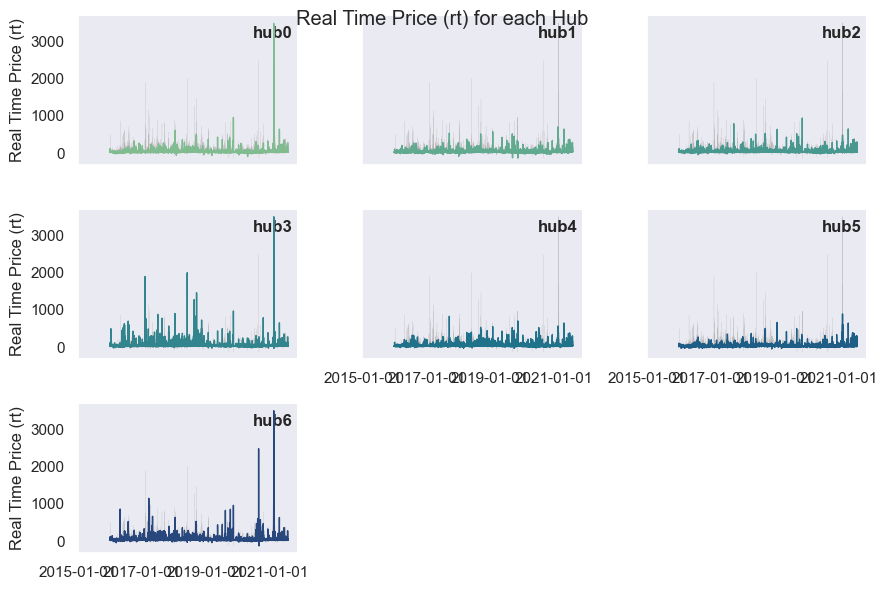

In [13]:
PlotMultipleGraphs(data_to_plot_rt, 'rt', "Real Time Price (rt) for each Hub", "Real Time Price (rt)")

###### Observations for Real Time prices (rt) 
1. Not all Hubs spike at the same time
2. Hub1, Hub2, Hub4, Hub5 real time price spikes are smaller then those of Hub0, Hub3, Hub6.
3. Hub0, Hub3, Hub6 seem to spike at the same time.
4. Hub1, Hub2, Hub4, Hub5 seem to spike at the same time.

<a id='rtpobs'>.</a>

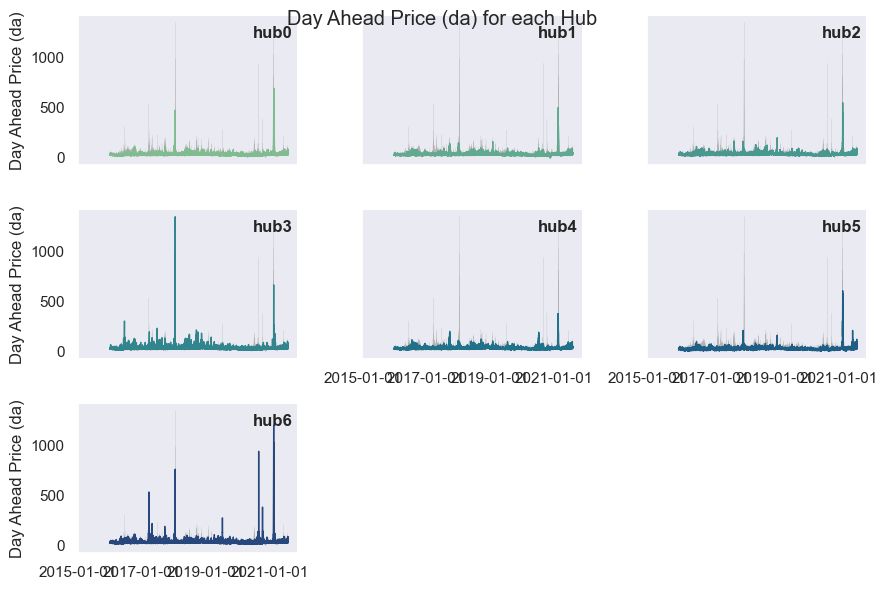

In [14]:
PlotMultipleGraphs(data_to_plot_da, 'da', "Day Ahead Price (da) for each Hub", "Day Ahead Price (da)")

#### Visualisation of Data with respect to Weekdays and Month

In [15]:
from Scripts.utilityscriptsq2 import BoxPlot

##### For Real Time Price (rt)

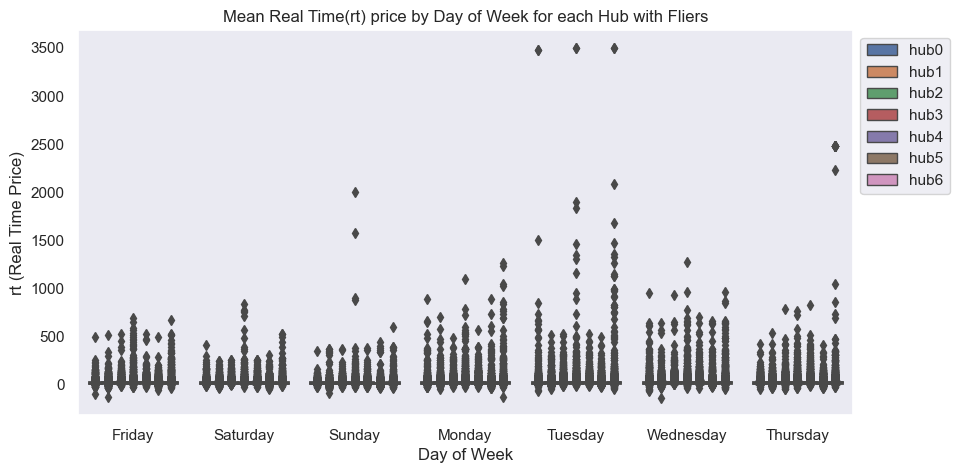

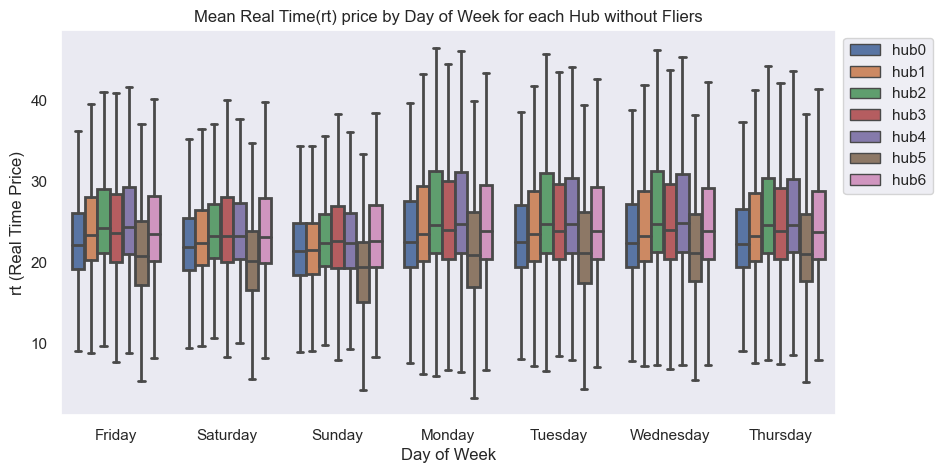

In [16]:
## Average Real Time price v.s. day of the week
data_to_plot_rt['weekday'] = data_to_plot_rt.index.day_name()
data_to_plot_rt['month'] = data_to_plot_rt.index.month

plot_args={
    'x':'weekday',
    'y':'rt',
    'hue':'cols',
    'xlabel':'Day of Week',
    'ylabel':'rt (Real Time Price)',
    'title':'Mean Real Time(rt) price by Day of Week for each Hub with Fliers',
    'showfliers':True}

BoxPlot(data_to_plot_rt, **plot_args)

plot_args['title'] = 'Mean Real Time(rt) price by Day of Week for each Hub without Fliers'
plot_args['showfliers'] = False
BoxPlot(data_to_plot_rt, **plot_args)

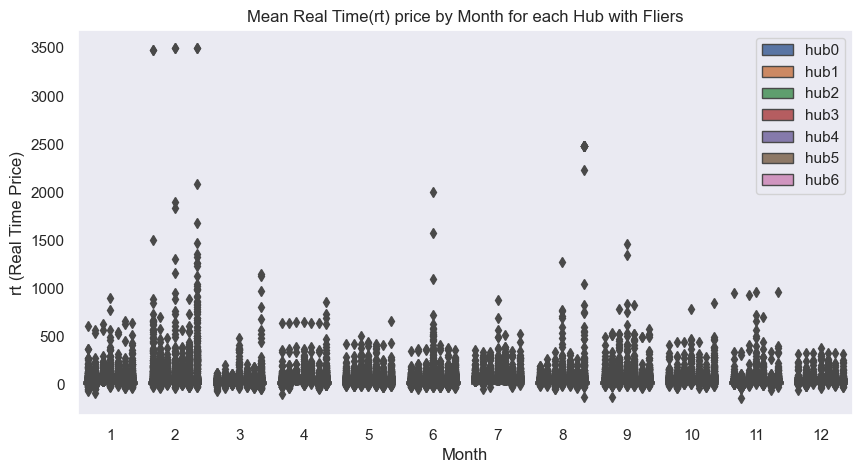

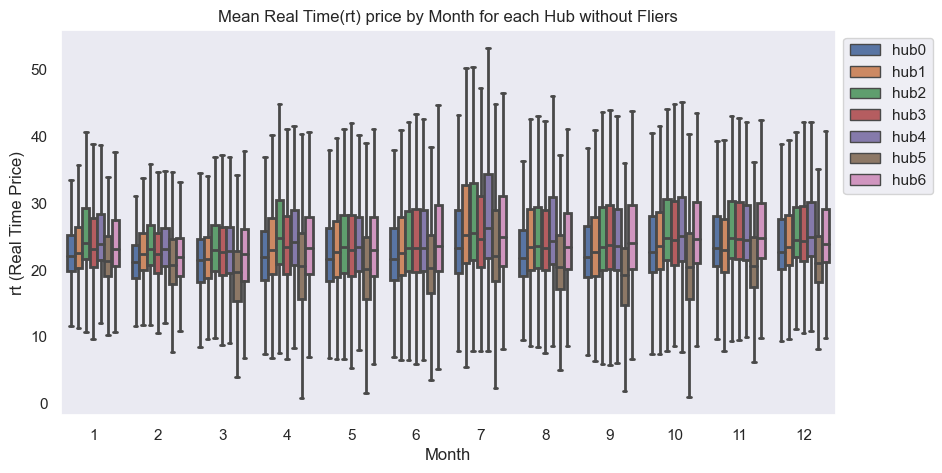

In [17]:
## Average Real Time price v.s. month

plot_args={
    'x':'month',
    'y':'rt',
    'hue':'cols',
    'xlabel':'Month',
    'ylabel':'rt (Real Time Price)',
    'title':'Mean Real Time(rt) price by Month for each Hub with Fliers',
    'showfliers':True}

BoxPlot(data_to_plot_rt, **plot_args)

plot_args['title'] = 'Mean Real Time(rt) price by Month for each Hub without Fliers'
plot_args['showfliers'] = False
BoxPlot(data_to_plot_rt, **plot_args)

##### For Day Ahead Price (da)

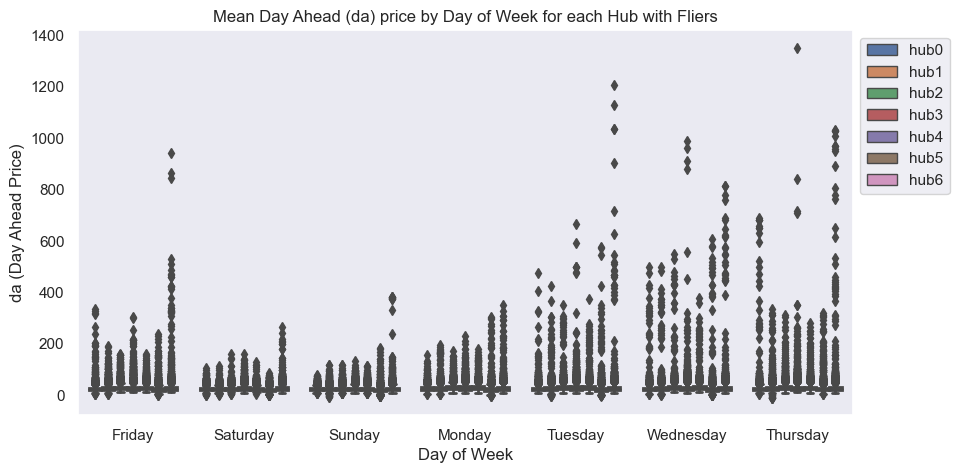

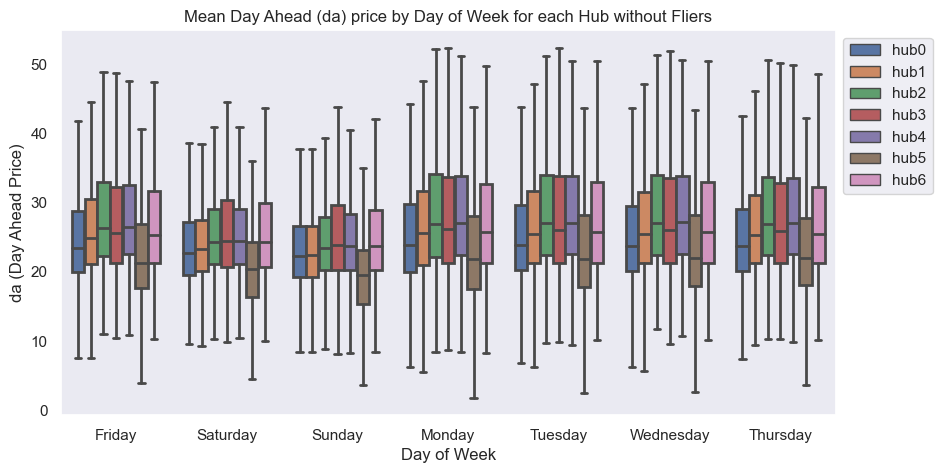

In [18]:
## Average Day Ahead price v.s. day of the week
data_to_plot_da['weekday'] = data_to_plot_da.index.day_name()
data_to_plot_da['month'] = data_to_plot_da.index.month

plot_args={
    'x':'weekday',
    'y':'da',
    'hue':'cols',
    'xlabel':'Day of Week',
    'ylabel':'da (Day Ahead Price)',
    'title':'Mean Day Ahead (da) price by Day of Week for each Hub with Fliers',
    'showfliers':True}

BoxPlot(data_to_plot_da, **plot_args)

plot_args['title'] = 'Mean Day Ahead (da) price by Day of Week for each Hub without Fliers'
plot_args['showfliers'] = False
BoxPlot(data_to_plot_da, **plot_args)

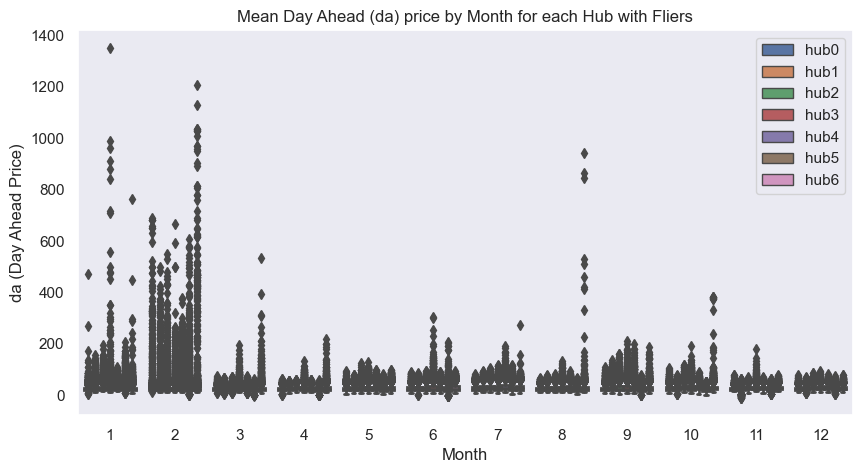

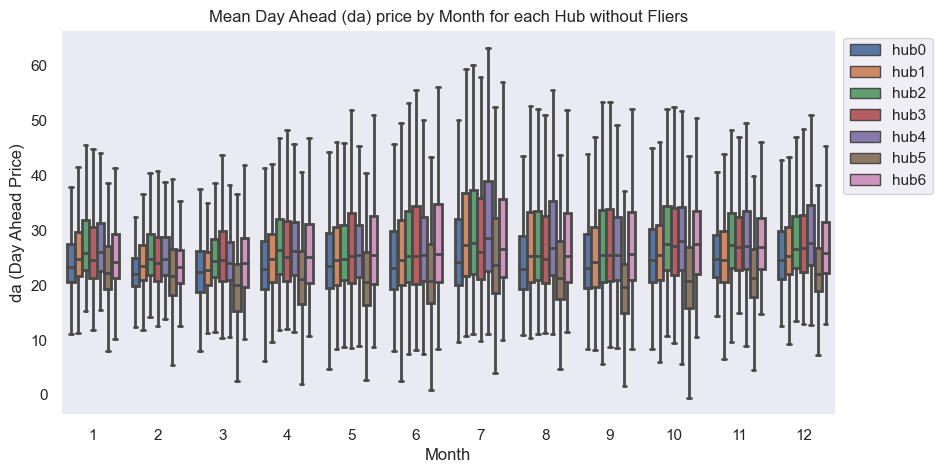

In [19]:
## Average Day Ahead price v.s. month
plot_args={
    'x':'month',
    'y':'da',
    'hue':'cols',
    'xlabel':'Month',
    'ylabel':'da (Day Ahead Price)',
    'title':'Mean Day Ahead (da) price by Month for each Hub with Fliers',
    'showfliers':True}

BoxPlot(data_to_plot_da, **plot_args)

plot_args['title'] = 'Mean Day Ahead (da) price by Month for each Hub without Fliers'
plot_args['showfliers'] = False
BoxPlot(data_to_plot_da, **plot_args)

###### Observations
We notice that the extreme values are not necessarily related to time (**H1**), but that the average behavior is related to the period of the year and the days of the week.<br>
$\Rightarrow$ My gues is that a strategy that makes profits on days when the market behaves normally would benefit from taking into account time variables (days, months, etc...). But an approach that seeks to make profits on peaks would benefit from not taking the time variable into account.

### Plotting Correlation between variables

In [20]:
from Scripts.utilityscriptsq2 import create_features, plot_cor

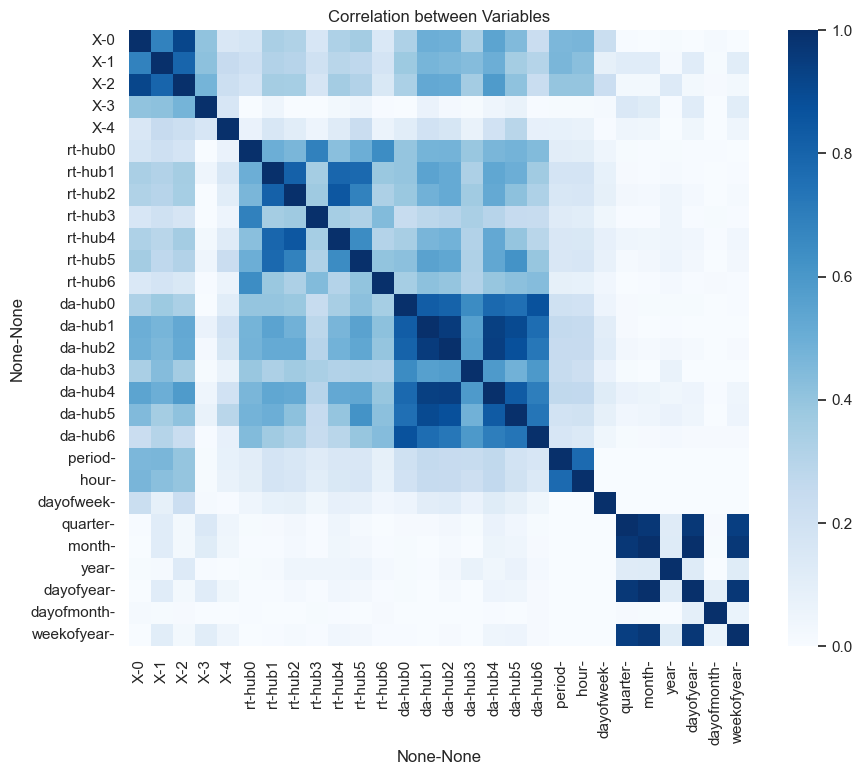

In [21]:
# Adding time features for correlation Analysis
time_features = create_features(data_no_missing_values)
data_no_missing_values_with_time_features = pd.concat([data_no_missing_values, time_features], axis=1)
plot_cor(data_no_missing_values_with_time_features)

#### Printing the correlation values

In [22]:
from Scripts.utilityscriptsq2 import PrintCorBetweenExplainedAndResponseVars
response_variables = [el for el in data_no_missing_values_with_time_features.columns if 'rt' in el or 'da' in el]

In [23]:
PrintCorBetweenExplainedAndResponseVars(data_no_missing_values_with_time_features, 'period', response_variables)

The average correlation between `period` and the response variables is : -0.1818


In [24]:
X_var_names = [el for el in data_no_missing_values_with_time_features.columns if 'X' in el]
PrintCorBetweenExplainedAndResponseVars(data_no_missing_values_with_time_features, 'period', X_var_names, 'the explanatory variables X')

The average correlation between `period` and the explanatory variables X is : -0.2464


In [25]:
PrintCorBetweenExplainedAndResponseVars(data_no_missing_values_with_time_features, 'dayofweek', response_variables)

The average correlation between `dayofweek` and the response variables is : -0.0751


In [26]:
# Cor between X and response variables
X_var_names = [el for el in data_no_missing_values_with_time_features.columns if 'X' in el]
for X_var in X_var_names:
    PrintCorBetweenExplainedAndResponseVars(data_no_missing_values_with_time_features, X_var, response_variables)

The average correlation between `X_0` and the response variables is : 0.3359
The average correlation between `X_1` and the response variables is : 0.3330
The average correlation between `X_2` and the response variables is : 0.3454
The average correlation between `X_3` and the response variables is : -0.0230
The average correlation between `X_4` and the response variables is : -0.1368


In [27]:
PrintCorBetweenExplainedAndResponseVars(data_no_missing_values_with_time_features, ('X', '1'), X_var_names, 'the explanatory variables X')

The average correlation between `X_1` and the explanatory variables X is : 0.3633


###### Observations
1. The `period` seems to be the time features with the highest correlation compared to the other time features. It is also not that correlated to the explanatory variables `X_i`. $\Rightarrow$ We should take it into account especially if we have an autoregressive model.
2. Also, the explanatory variables `X_0`, `X_1`, `X_2` are highly correlated amoung themselves. Additionally they are highly correlated with the response variables that needs to be predicted (`rt` and `da`).

### Plotting the correlation between the variables only when price spikes happen

In [28]:
## Some statistics on our data
data_no_missing_values[['rt', 'da']].describe()

rt                                                          \
               hub0          hub1          hub2          hub3          hub4   
count  48937.000000  48937.000000  48937.000000  48937.000000  48937.000000   
mean      25.399434     26.155576     28.122397     28.780042     28.230787   
std       31.058651     18.429564     20.011079     42.986186     21.259872   
min      -96.380000   -135.190000    -47.030000    -36.860000    -37.060000   
25%       19.190000     19.800000     20.820000     20.110000     20.760000   
50%       22.090000     22.850000     23.940000     23.490000     23.990000   
75%       26.370000     27.790000     29.320000     28.740000     29.230000   
max     3480.750000    703.010000    936.400000   3500.000000    826.380000   

                                             da                              \
               hub5          hub6          hub0          hub1          hub2   
count  48937.000000  48937.000000  48937.000000  48937.000000  48937.000000   
mean      23.040884     29.316718     25.744736     26.966241     28.713706   
std       19.652196     57.673591     16.061596     13.626011     14.257844   
min      -53.450000   -132.210000      1.380000    -10.140000      5.630000   
25%       16.970000     20.120000     19.880000     20.700000     21.830000   
50%       20.570000     23.440000     23.300000     24.500000     25.780000   
75%       25.000000     28.540000     28.610000     30.150000     32.300000   
max      888.140000   3500.000000    689.590000    498.890000    547.480000   

                                                               
               hub3          hub4          hub5          hub6  
count  48937.000000  48937.000000  48937.000000  48937.000000  
mean      29.174765     28.684558     23.380052     29.395482  
std       20.224959     12.850292     16.482161     30.303725  
min        8.170000      5.590000     -3.680000      8.330000  
25%       21.010000     21.930000     17.290000     21.010000  
50%       25.340000     26.000000     21.180000     25.090000  
75%       32.240000     32.180000     26.570000     31.580000  
max     1351.680000    376.630000    606.820000   1207.280000

#### Z-Score and three-sigma
**In this section, we aim to analyze the data only associated with the spikes. Therefore, we have to identify the outliers and seperate them from the average market behavior.**<br><br>

Computing the Z-Score $Z=\cfrac{x-\mu}{\sigma}$ for each value in each row, where $\mu=\mathbb{E}[X]$ is the mean, and $\sigma=\sqrt{\mathrm{Var}[X]}$ is the standard deviation.<br>
 If $|Z|>3$, then according to the three-sigma rule, $Z$ is an outlier!

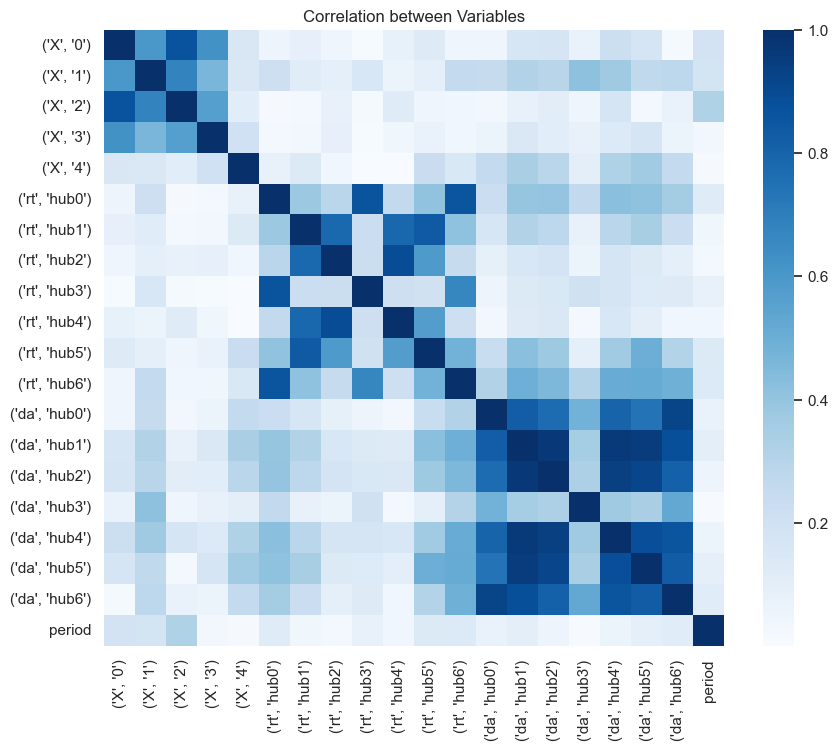

In [29]:
# Extracting the outliers from the data
z_score  = stats.zscore(data_no_missing_values[['rt', 'da']])
outliers = data_no_missing_values[(np.abs(z_score)>3).values]#3 here signifiez 3Sigma

# Adding the period to the outliers
outliers_with_period = pd.concat([outliers, create_features(outliers).period], axis=1)

plot_cor(outliers_with_period)

We confirm our observations from the section [Simple plot of the explanatory variables `rt` and `da`](#rtpobs): 
1. Hub0, Hub3 and Hub6 rt prices seem to spike at the same time !
2. Hub1, Hub2, Hub4 and Hub5 rt prices seem to spike at the same time !

However, for the Day Ahead Price (da), Hub3 seems to be the only hub that is independent from the rest. All hubs are highly correlated except Hub3.

In [30]:
average_percentage_of_outliers_for_explanatory_variables = ((np.abs(z_score)>3).sum()/z_score.shape[0]*100).mean()
print('The Average Percentage of Outliers for each of the explanatory variables is: {0:.2f}%'.format(average_percentage_of_outliers_for_explanatory_variables))

The Average Percentage of Outliers for each of the explanatory variables is: 0.86%


If we follow the three-sigma rule, we should expect that only $0.3$% of the data points fall in the segment described by $|Z|>3$. However, on average, it is not the case for our explanatory variables: we get on average $0.86$% of our data points that fall in the $|Z|>3$ segment. It means that our explanatory variables have on average a longer tail then a gaussian distribution does.

##### **Showing correlation only with response variables**

In [31]:
response_variables = [el for el in data_no_missing_values_with_time_features.columns if 'rt' in el or 'da' in el]
PrintCorBetweenExplainedAndResponseVars(outliers_with_period, 'period', response_variables)

The average correlation between `period` and the response variables is : -0.0681


In [32]:
X_var_names = [el for el in data_no_missing_values_with_time_features.columns if 'X' in el]
for X_var in X_var_names:
    PrintCorBetweenExplainedAndResponseVars(outliers_with_period, X_var, response_variables)

The average correlation between `X_0` and the response variables is : 0.0947
The average correlation between `X_1` and the response variables is : 0.2281
The average correlation between `X_2` and the response variables is : 0.0306
The average correlation between `X_3` and the response variables is : -0.0576
The average correlation between `X_4` and the response variables is : -0.1634


###### Observations
1. When we isolate outliers, we see that the explanatory variable `X_1` is particularly correlated with the response variables `rt` and `da` compared to the other explanatory variables. We also observe that `period` is still a bit correlated with the response variables. <br>
$\Rightarrow$ A strategy that wants to capitalize outliers should take into account the explanatory variables `X_1`, and `X_0`. It should also take into account the `period` only if it is autoregressive and timebased (not highly correlated, but still not negligeable).
2. Moreover, we notice that also for the outliers `X_0`, `X_1`, `X_2`, and `X_3` seem to be highly correlated. `X_4` seems to be independent from the others. <br>
$\Rightarrow$ If I have time I should do a PCA or an other dimensionality reduction technique on `X` variables. 

In [33]:
## Following our observations we add the period to the dataset
data_no_missing_values_with_period = data_no_missing_values.copy()
data_no_missing_values_with_period['period'] = create_features(data_no_missing_values).period
data_no_missing_values_with_period.head()

X                                       rt         \
                         0      1      2      3            4   hub0   hub1   
2016-01-01 00:00:00  16.94  17.14  38.67  18.21  1039.295714  17.81  17.94   
2016-01-01 01:00:00  16.24  17.04  36.44  19.96  1042.631429  19.62  19.73   
2016-01-01 02:00:00  15.71  16.63  35.76  19.59  1044.527143  19.36  18.78   
2016-01-01 03:00:00  15.33  16.43  35.12  19.59  1053.900000  18.13  17.33   
2016-01-01 04:00:00  15.12  16.30  34.79  19.59  1062.230000  17.71  16.75   

                                                           da                \
                      hub2   hub3   hub4   hub5   hub6   hub0   hub1   hub2   
2016-01-01 00:00:00  18.40  18.23  18.13  16.29  18.67  20.43  21.52  21.43   
2016-01-01 01:00:00  20.43  20.11  20.27  18.66  20.40  20.69  20.79  20.11   
2016-01-01 02:00:00  19.47  19.69  19.33  16.62  19.97  19.99  20.73  19.58   
2016-01-01 03:00:00  18.01  18.49  17.87  14.66  18.79  19.14  19.07  18.49   
2016-01-01 04:00:00  17.42  18.05  17.27  13.65  18.43  19.12  18.98  17.94   

                                                   period  
                      hub3   hub4   hub5   hub6            
2016-01-01 00:00:00  21.30  21.71  18.69  21.21  0.000000  
2016-01-01 01:00:00  20.53  20.08  16.16  20.17  0.258819  
2016-01-01 02:00:00  20.36  19.71  15.78  20.25  0.500000  
2016-01-01 03:00:00  18.99  18.32  13.87  19.08  0.707107  
2016-01-01 04:00:00  18.92  17.83  12.73  19.06  0.866025

## Split the Dataset

In [34]:
da = data_no_missing_values_with_period["da"]
rt = data_no_missing_values_with_period["rt"]

split = datetime(2020,8,1)

data_train = data_no_missing_values_with_period[:split]
data_validate = data_no_missing_values_with_period[split:]

da_train = da.loc[:split]
da_validate = da.loc[split:]

rt_train = rt.loc[:split]
rt_validate = rt.loc[split:]

##  Implementation

### Strategy and Model chosen
In order to take advantage of the sequentiality of the data, we choose an RNN to be our predictive model. Precisely, we use an RNN layer called Long Short-Term Memory (LSTM). The model will utilize the last 48h of data  and only return the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

<p align="center">
    <img src=Images/lstm_1_window.png/>
</p>

We are aware that this model doesn't take advantage of the multiple observations made previously. This is kept for future work ;).

In [35]:
from Scripts.modelutilityscriptq2 import WindowGenerator, plot_history
from Scripts.trainingmodelq2 import hourly_results_loss, compile_and_fit

In [36]:
## Setting up variables for training
BATCH_SIZE= 32
MAX_EPOCHS= 20
OUT_STEPS = 48
shift     = 1
LR        = 0.01
optimizer = tf.keras.optimizers.Adam
patience  = 2
label_columns = [el for el in response_variables if 'rt' in el or 'da' in el]

wide_window = WindowGenerator(train_df=data_train, val_df=data_validate, batch_size=BATCH_SIZE,
                               input_width=OUT_STEPS,
                               label_width=1,
                               shift=shift,
                               label_columns=label_columns)

wide_window

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48]
Label column name(s): [('rt', 'hub0'), ('rt', 'hub1'), ('rt', 'hub2'), ('rt', 'hub3'), ('rt', 'hub4'), ('rt', 'hub5'), ('rt', 'hub6'), ('da', 'hub0'), ('da', 'hub1'), ('da', 'hub2'), ('da', 'hub3'), ('da', 'hub4'), ('da', 'hub5'), ('da', 'hub6')]

In [37]:
## Defining the model
number_of_hubs = len([el for el in response_variables if 'rt' in el])
output_dim = 4

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True),
    # tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True),
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=False),
    # Shape => [batch, 1, features]
    tf.keras.layers.Dense(units=number_of_hubs*output_dim),
    tf.keras.layers.Reshape((-1, output_dim, number_of_hubs)),
    # Adding constraints vl>=0 and vs>=0 into the model's prediction
    tf.keras.layers.Lambda(lambda x: tf.concat([tf.nn.relu(x[:, :, 0])[:, :, None, :], x[:, :, 1][:, :, None, :], tf.nn.relu(x[:, :, 2][:, :, None, :]), x[:, :, 3][:, :, None, :]], axis=2))
])

In [38]:
## Doing some stats on first predictions before training
x, y_true = next(iter(wide_window.train))
y_pred = lstm_model(x)
column_names_for_prediction = pd.MultiIndex.from_tuples([(el, hub) for el in ['v_plus', 'bid_price', 'v_neg', 'offer_price'] for hub in ['hub'+str(i) for i in range(7)]])
initial_predictions_before_training_df = pd.DataFrame(tf.squeeze(y_pred).numpy().reshape(BATCH_SIZE, -1), columns=column_names_for_prediction)
initial_predictions_before_training_df[['v_plus', 'v_neg']].describe()

v_plus                                                         \
        hub0       hub1       hub2       hub3       hub4       hub5   
count   32.0  32.000000  32.000000  32.000000  32.000000  32.000000   
mean     0.0   0.305865   0.069021   0.112914   0.021124   0.047150   
std      0.0   0.091483   0.075540   0.076826   0.036618   0.100763   
min      0.0   0.128407   0.000000   0.000000   0.000000   0.000000   
25%      0.0   0.217810   0.000000   0.037864   0.000000   0.000000   
50%      0.0   0.308860   0.028956   0.127763   0.000000   0.000000   
75%      0.0   0.405217   0.155829   0.181571   0.030691   0.001221   
max      0.0   0.433103   0.188819   0.206405   0.095697   0.351947   

                 v_neg                                                          
            hub6  hub0       hub1       hub2  hub3       hub4  hub5       hub6  
count  32.000000  32.0  32.000000  32.000000  32.0  32.000000  32.0  32.000000  
mean    0.019478   0.0   0.014522   0.003002   0.0   0.540811   0.0   0.161553  
std     0.030197   0.0   0.033667   0.016982   0.0   0.059862   0.0   0.092872  
min     0.000000   0.0   0.000000   0.000000   0.0   0.427020   0.0   0.000000  
25%     0.000000   0.0   0.000000   0.000000   0.0   0.504143   0.0   0.090137  
50%     0.000000   0.0   0.000000   0.000000   0.0   0.530517   0.0   0.207336  
75%     0.034549   0.0   0.000000   0.000000   0.0   0.602494   0.0   0.225526  
max     0.083326   0.0   0.133272   0.096065   0.0   0.630893   0.0   0.277252

###### Observations
1. The initial volume traded is pretty low, this can explain how it's PNL slowly increases from epoch to epoch.
2. Also, we notice that the $v \geq 0$ constraint is respected !

In [39]:
# #  Uncomment if you wish to retrain your own model
# lstm_hist = compile_and_fit(lstm_model, wide_window, loss=hourly_results_loss, optimizer=optimizer, patience=patience, lr=LR, epochs=MAX_EPOCHS)
# plot_history(lstm_hist, model_name="Simple LSTM")

#### Training history of best model
![BestModel](Images/Training_hist.png)

In [40]:
## Laoding best model
best_model_weights_path = 'Models/best_model.tf'
lstm_model.load_weights(best_model_weights_path)

### Exploring our results

In [41]:
def hourly_results(v_plus, bid_price, v_neg, offer_price, da, rt):
    
    return (v_plus * (da <= bid_price) * (rt - da)) + (v_neg * (offer_price < da) * (da - rt))

In [42]:
def worst_loss(results):
    
    return min(results.sum(axis=1))

In [43]:
y_pred = lstm_model.predict(wide_window.val)
bids, v_long, offers, v_short = y_pred[:, -1, 0], y_pred[:, -1, 1], y_pred[:, -1, 2], y_pred[:, -1, 3]

273/273 [==============================] - 2s 4ms/step


-815.8427528452874
Is the constraint respected: True
PNL for the entire validation set: 23740.349


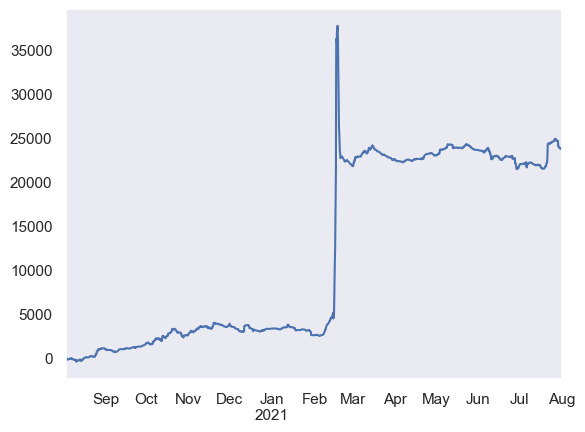

In [44]:
results = hourly_results(v_long, bids, v_short, offers, da_validate[48:], rt_validate[48:])
pnl = results.sum(axis=1).cumsum().plot()
constraint = worst_loss(results)
print(constraint)
print("Is the constraint respected:",constraint>-1000)
print('PNL for the entire validation set: {0:.3f}'.format(results.sum(axis=1).sum().sum()))

##### Results Observation

At first glance the results look promising. Moreover, the **min(hourly_results)**$>-1000$ constraint is verified. <br>
Nevertheless, we must not be fooled by seemingly good results. After diving a little deeper, we notice that the volume and the price inferred by the model are approximately constant (see statistics below). It learned to short `hub1`, `hub2`, `hub3`, `hub5`, `hub6`, when the price is right. It makes sense considereing that our correlation analysis showed that the prices of those hubs were highly correlated when price spikes occured.<br>
However, this is not a sustainable strategy on the long term $\Rightarrow$ this algorithm cannot be deployed...

In [45]:
initial_predictions_before_training_df = pd.DataFrame(tf.squeeze(y_pred).numpy().reshape(y_pred.shape[0], -1), columns=column_names_for_prediction)
initial_predictions_before_training_df[['v_plus', 'v_neg']].describe()

v_plus                                                         \
              hub0         hub1         hub2    hub3         hub4    hub5   
count  8713.000000  8713.000000  8713.000000  8713.0  8713.000000  8713.0   
mean      1.246194     0.102462     0.165937     0.0     0.516799     0.0   
std       0.000078     0.000003     0.000009     0.0     0.000012     0.0   
min       1.246194     0.102462     0.165937     0.0     0.516799     0.0   
25%       1.246194     0.102462     0.165937     0.0     0.516799     0.0   
50%       1.246194     0.102462     0.165937     0.0     0.516799     0.0   
75%       1.246194     0.102462     0.165937     0.0     0.516799     0.0   
max       1.246194     0.102462     0.165938     0.0     0.516799     0.0   

                v_neg                                                 \
         hub6    hub0         hub1         hub2         hub3    hub4   
count  8713.0  8713.0  8713.000000  8713.000000  8713.000000  8713.0   
mean      0.0     0.0  3170.550781  1968.875488  3165.206543     0.0   
std       0.0     0.0     0.093021     0.086673     0.221689     0.0   
min       0.0     0.0  3170.550537  1968.875977  3165.206055     0.0   
25%       0.0     0.0  3170.550781  1968.875977  3165.206055     0.0   
50%       0.0     0.0  3170.550781  1968.875977  3165.206055     0.0   
75%       0.0     0.0  3170.550781  1968.875977  3165.206055     0.0   
max       0.0     0.0  3170.550781  1968.875977  3165.206055     0.0   

                                 
              hub5         hub6  
count  8713.000000  8713.000000  
mean   1824.320312  3103.862305  
std       0.109997     0.108647  
min    1824.320312  3103.862061  
25%    1824.320312  3103.862061  
50%    1824.320312  3103.862061  
75%    1824.320312  3103.862061  
max    1824.320312  3103.862061

In [46]:
initial_predictions_before_training_df[['bid_price', 'offer_price']].describe()

bid_price                                                      \
              hub0         hub1         hub2         hub3         hub4   
count  8713.000000  8713.000000  8713.000000  8713.000000  8713.000000   
mean      0.713039     0.213735     1.869953     0.741984     0.780672   
std       0.000025     0.000008     0.000115     0.000056     0.000059   
min       0.713039     0.213735     1.869953     0.741984     0.780672   
25%       0.713039     0.213735     1.869953     0.741984     0.780673   
50%       0.713039     0.213735     1.869953     0.741984     0.780673   
75%       0.713039     0.213735     1.869953     0.741984     0.780673   
max       0.713039     0.213735     1.869953     0.741984     0.780673   

                                 offer_price                            \
              hub5         hub6         hub0         hub1         hub2   
count  8713.000000  8713.000000  8713.000000  8713.000000  8713.000000   
mean      0.238216    -0.021671    -1.749969     2.524963     2.237135   
std       0.000026     0.000002     0.000028     0.000248     0.000027   
min       0.238216    -0.021671    -1.749969     2.524963     2.237135   
25%       0.238216    -0.021671    -1.749969     2.524963     2.237135   
50%       0.238216    -0.021671    -1.749969     2.524963     2.237135   
75%       0.238216    -0.021671    -1.749969     2.524963     2.237135   
max       0.238216    -0.021671    -1.749969     2.524963     2.237135   

                                                           
              hub3         hub4         hub5         hub6  
count  8713.000000  8713.000000  8713.000000  8713.000000  
mean     -2.648338     1.509497     0.719072    -0.215868  
std       0.000089     0.000040     0.000038     0.000017  
min      -2.648338     1.509496     0.719072    -0.215868  
25%      -2.648338     1.509496     0.719072    -0.215868  
50%      -2.648338     1.509496     0.719072    -0.215868  
75%      -2.648338     1.509496     0.719072    -0.215868  
max      -2.648338     1.509496     0.719072    -0.215868

#### Disadvantages of this approach
1. The main constraint **min(hourly_results)**$>-1000$ is not hard coded into the model's optimization. Luck was involved to satify this constraint + hyper parameter tuning.
2. Performance of the model varies a lot for each training.
3. The model yields constant predictions consistenly, it doesn't react to market variations $\Rightarrow$ high risk of failure.
4. It doesn't utilize the past `rt` and `da` data that we have historically.

$\Rightarrow$ This approach is clearly not optimal.

## Results

We will run this on the test data we have held back and will discuss results if you are selected for a final technical interview.

In [47]:
# X_test, da_test, rt_test = read_test_data() # held back by CWP
# obj.fit(X, da, rt)
# bids, v_long, offers, v_short = obj.predict(X_test)
# result = daily_result( v_long, bids, v_short, offers)

## Suggested Improvements
1. Have a model that predicts `rt` and `da` seperately. Use the data predicted from the model to maximise the PNL taking into account the constraint **min(hourly_results)**$>-1000$. 
2. Seperate the data between regular market behavior and spikes. Train different models on each.
3. Use a Reinforcement Learning framework to implement constraint and solve partially the problem. This inspiration comes from this RL [git project](https://github.com/Learningchipmunk/RL-Agents-for-Automated-Stock-Trading).

Suggestions to hardcode constraints:
1. $p^l < p^s \Rightarrow$ on peut l'implémenter ainsi $p^s$ = Relu($p^s - p^l$) + $p^l$. 
2. For the **min(hourly_results)**$>-1000$ constraint. We could use reinforcement learning. Each time profits goes under 1000, its game over and we restart sim.
https://arxiv.org/pdf/1707.07338.pdf